# Dirichlet model fitting to nutrient productivity
Based on http://dirichletreg.r-forge.r-project.org/


In [365]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import ternary
import theano.tensor as tt
import seaborn as sns
import scipy as sp
import pdb
import os
import arviz as az
from matplotlib.patches import Ellipse, transforms
from itertools import combinations
#import ternary

# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

Dataset are proportion of nutrient productivity by fish functional groups, for zinc.mg

In [712]:
# Import data
nut = pd.read_csv("zinc.mg_unscaled.csv")
nut.head()

y = nut[["herbivore-detritivore","herbivore-macroalgae","invertivore-mobile","omnivore","piscivore","planktivore"]]
# Grab fg names
hnames = list(y[:-1])
y = y.to_numpy()
y = y.round(2)+0.000001
# Make y's sum to 1
y = y/y.sum(axis=1,keepdims=1)
nfg = y.shape[1]

# export fitted df
y2=pd.DataFrame(y)
y2.to_csv('zinc_focal.csv', index=False)

# # identify predictors
hc = stdize(nut.hard_coral).to_numpy()
ma = stdize(nut.macroalgae).to_numpy()
bs = stdize(nut.bare_substrate).to_numpy()
ta = stdize(nut.turf_algae).to_numpy()
pop = stdize(nut.pop_count).to_numpy()
rt = pd.Categorical(nut.reef_type)
grav_nc = stdize(nut.grav_nc).to_numpy()
dep = stdize(nut.depth).to_numpy()

## categorical levels
reef_type = list(np.sort(pd.unique(nut["reef_type"])))
rt = np.array([reef_type.index(x) for x in nut["reef_type"]])

manage = list(np.sort(pd.unique(nut["management_rules"])))
mr = np.array([manage.index(x) for x in nut["management_rules"]])

# if site nested in country, use subindexall
# country,c = subindexall(nut["country"], nut["site"])
# else
country = list(np.sort(pd.unique(nut["country"])))
c = np.array([country.index(x) for x in nut["country"]])

# site is almost n = 1 for all, so would not converge sensibly
# site = list(np.sort(pd.unique(nut["site"])))
# s = np.array([site.index(x) for x in nut["site"]])

1.630427175648147

Now build the model

In [615]:
coords={'reef_type':reef_type, 'country':country,'site':site,'nfg':nfg}

with pm.Model(coords=coords) as BDM:
    intercept = pm.Normal('intercept', 0, 2, shape=nfg)
    
    # conts
    hard_coral = pm.Normal('hard_coral', 0, 0.5, shape=nfg)
    macroalgae = pm.Normal('macroalgae', 0, 0.5, shape=nfg)
    bare_sub = pm.Normal('bare_sub', 0, 0.5, shape=nfg)
    turf = pm.Normal('turf', 0, 0.5, shape=nfg)
    population = pm.Normal('population', 0, 0.5, shape=nfg)
    gravity = pm.Normal('gravity', 0, 1, shape=nfg)
    depth = pm.Normal('depth', 0, 0.5, shape=nfg)
    
    # cats
    reeftype_x = pm.Normal("reeftype_x", 0, 2, shape = (len(reef_type), nfg))
    manage_x = pm.Normal("manage_x", 0, 2, shape = (len(manage), nfg))
    
    # country nested in global intrcept
    σ_c = pm.Exponential('Sigma_country', 1)
    β0_cnc = pm.Normal('β0_cnc', 0, 1, shape = (len(country), nfg))
    β0_c = pm.Normal('β0_c', intercept+β0_cnc*σ_c, shape = (len(country), nfg))
    
    # Site
#     σ_s = pm.Exponential('Sigma_site', 1)
#     β0_snc = pm.Normal('β0_snc', 0, 1, shape = (len(site), nfg))
#     β0_s = pm.Normal('β0_s', β0_c[Ic]+β0_snc*σ_c, shape = (len(site), nfg)) # check w Aaron
    
    α = pm.Deterministic('alpha', tt.exp(#intercept +
#                                         β0_s[s, :None] +
                                         β0_c[c, :None] +
                                         reeftype_x[rt,:None] +
                                         manage_x[mr,:None] +
                                         hard_coral*hc[:,None]+macroalgae*ma[:,None]+bare_sub*bs[:,None]+turf*ta[:,None]+
                                         gravity*grav_nc[:,None] + population*pop[:,None]+
                                         depth*dep[:,None]))
    Yi = pm.Dirichlet('Yi', α, observed=y)

Note the `[:,None]` in the code is to broadcast the predictor measurements across all fish functional groups.

In [616]:
for RV in BDM.basic_RVs:
    print(RV.name, RV.logp(BDM.test_point))

intercept -9.672514282587708
hard_coral -1.3547481158683645
macroalgae -1.3547481158683645
bare_sub -1.3547481158683645
turf -1.3547481158683645
population -1.3547481158683645
gravity -5.513631199228035
depth -1.3547481158683645
reeftype_x -48.36257141293857
manage_x -48.36257141293857
Sigma_country_log__ -1.0596601002984287
β0_cnc -22.054524796912148
β0_c -22.054524796912148
Yi 1795.3094035432796


In [617]:
with BDM:
    trace_dm = pm.sample()

/opt/anaconda3/lib/python3.7/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β0_c, β0_cnc, Sigma_country, manage_x, reeftype_x, depth, gravity, population, turf, bare_sub, macroalgae, hard_coral, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 262 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.


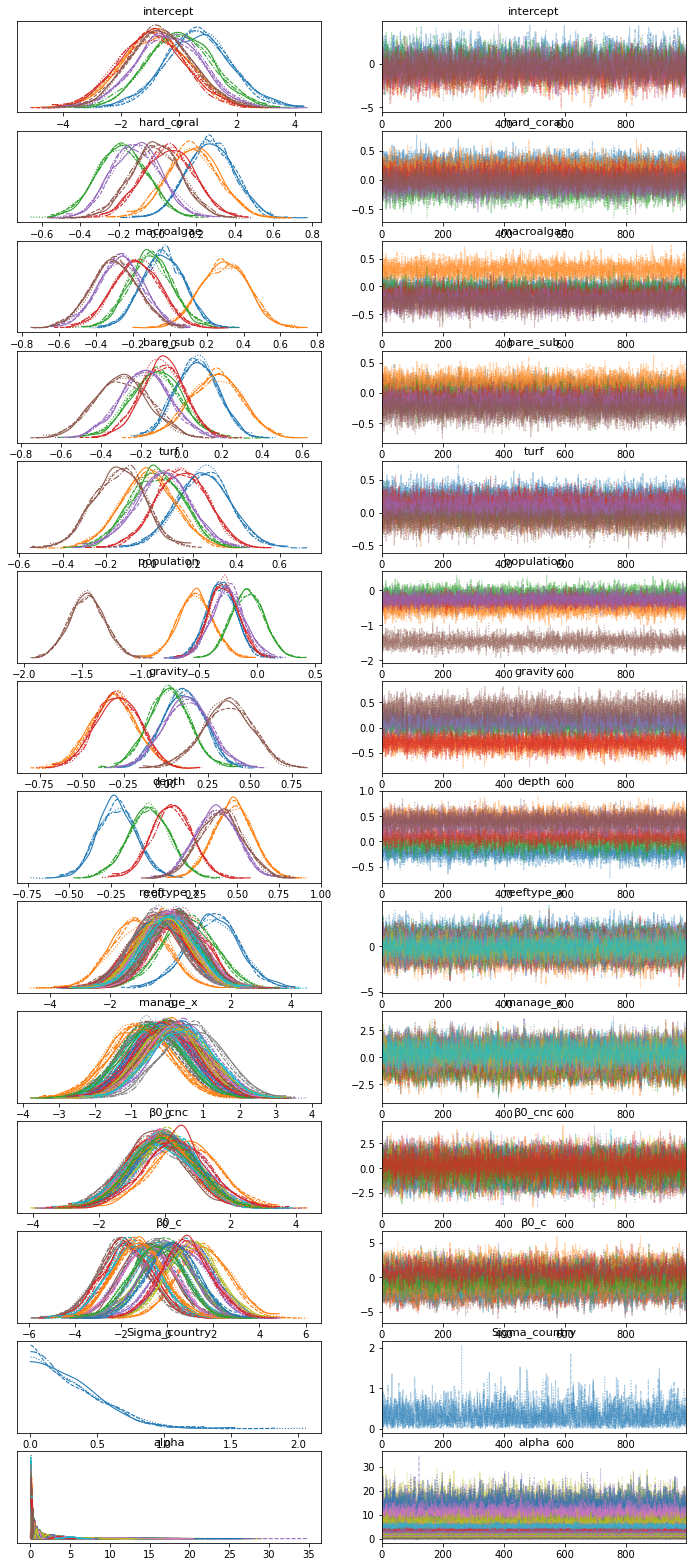

In [703]:
# pm.plot_trace(trace_dm);
# pm.summary(trace_dm)
# Plot traces
pm.plot_trace(trace_dm).ravel()[0].figure.savefig('Zinc_Trace.jpg')

In [620]:
# Export summary stats
tmp = pm.summary(trace_dm, var_names=['~Sigma_country'], hdi_prob=0.95)
varnames = np.array(list(tmp.index), dtype=object)
varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(np.repeat(country, nfg))*2)
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = np.repeat(reef_type, nfg)
varnames[match(grep('manage_x',list(varnames)),list(varnames))] = np.repeat(manage, nfg)

tmp['varname'] = list(varnames)
tmp['fg']=int(len(tmp)/nfg)*hnames

tmp.to_csv('zinc_posterior_summary.csv')

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


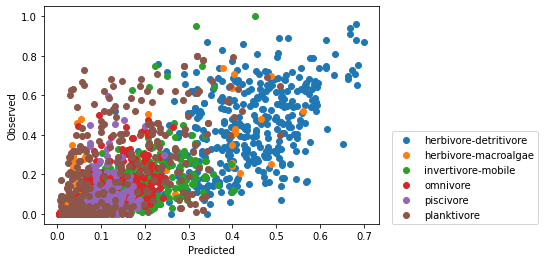

In [627]:
# Grab expected alphas
alpha = trace_dm['alpha'].T
alpha_0 = alpha.sum(0).mean(1)
Ex_alphas = alpha.mean(2)
Ex = Ex_alphas/alpha_0

## Predicted vs. observed
[plt.scatter(ei,yi,label=l) for yi,l,ei in zip(y.T,hnames,Ex)]
plt.ylabel('Observed'),plt.xlabel('Predicted')
plt.legend(loc=(1.04,0));

In [702]:
# extract trace for posterior counterfactuals in R
# posts = pm.trace_to_dataframe(trace_dm)
# posts.to_csv('zinc_posterior_trace.csv', index=False)
# posts.head()

out = pm.trace_to_dataframe(trace_dm)
varnames = np.array(list(out), dtype=object)
varnames[match(grep('β0_c',list(varnames)),list(varnames))] = np.array(list(np.repeat(country, nfg))*2)
varnames[match(grep('reeftype_x',list(varnames)),list(varnames))] = np.repeat(reef_type, nfg)
varnames[match(grep('manage_x',list(varnames)),list(varnames))] = np.repeat(manage, nfg)
out.columns=varnames
out.to_csv('zinc_posterior_trace.csv', index=False)

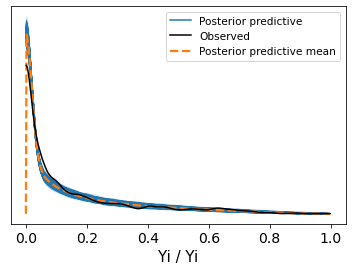

In [625]:
## posterior predictive distribution
with BDM:
    ppc = pm.sample_posterior_predictive(
        trace_dm, random_seed=43
    )

with BDM:
    az.plot_ppc(az.from_pymc3(posterior_predictive=ppc))

In [662]:
len(posts)

4000